In [ ]:
import tarfile
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras import applications
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.optimizers import SGD
from keras.models import Sequential, Model
import numpy as np
import pandas as pd
import shutil
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


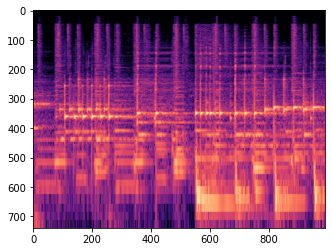

In [ ]:
import matplotlib.pyplot as plt

img = load_img('./Data/0/dan_trung10.png')
x = img_to_array(img)
g = plt.imshow(x/255.)

In [ ]:
batch_size = 32

#Data Augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)


#Normalize
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        './Data',  
        target_size=(288, 288),  
        batch_size=batch_size,
        class_mode='categorical',
        subset="training")  

validation_generator = train_datagen.flow_from_directory(
        './Data',  
        target_size=(288, 288),  
        batch_size=batch_size,
        class_mode='categorical',
        subset="validation")

Found 1653 images belonging to 8 classes.
Found 410 images belonging to 8 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
        
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X

In [ ]:
import os
import tensorflow as tf
import cv2
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import keras.backend as K

In [ ]:
nlabls = 8
def ResNet50(input_shape = (288, 288, 3), classes = nlabls):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [ ]:
model = ResNet50(input_shape = (288, 288, 3), classes = nlabls)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 294, 294, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 144, 144, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import keras
batch_size = 32
ntrain = 1653
nval = 410

# choosing Adam optimizer, also defining loss function and evaluation metrics
model.compile(
    optimizer=keras.optimizers.Adam(epsilon=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fitting the model over 100 epochs here
# cutoff criteria can be set for no of epochs 
# if the accuracy doesn't increase appreciable over iterations
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch = ntrain // batch_size,
    validation_steps = nval // batch_size
)

<ipython-input-19-9daf2546544e>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
51/51 [==============================] - 730s 14s/step - loss: 3.9304 - accuracy: 0.3726 - val_loss: 133.0233 - val_accuracy: 0.1849
Epoch 2/100
51/51 [==============================] - 74s 1s/step - loss: 0.4960 - accuracy: 0.8390 - val_loss: 8.6168 - val_accuracy: 0.1172
Epoch 3/100
51/51 [==============================] - 74s 1s/step - loss: 0.2418 - accuracy: 0.9241 - val_loss: 5.4418 - val_accuracy: 0.1120
Epoch 4/100
51/51 [==============================] - 74s 1s/step - loss: 0.2602 - accuracy: 0.9260 - val_loss: 3.7471 - val_accuracy: 0.2240
Epoch 5/100
51/51 [==============================] - 74s 1s/step - loss: 0.2087 - accuracy: 0.9358 - val_loss: 2.2873 - val_accuracy: 0.4271
Epoch 6/100
51/51 [==============================] - 76s 1s/step - loss: 0.1561 - accuracy: 0.9457 - val_loss: 4.0975 - val_accuracy: 0.2708
Epoch 7/100
51/51 [==============================] - 74s 1s/step - loss: 0.1411 - accuracy: 0.9568 - val_loss: 1.7799 - val_accuracy: 0.3672
Epoch 8/1

In [ ]:
test_generator = test_datagen.flow_from_directory(
        './Data',  
        target_size=(288, 288),  
        batch_size=batch_size,
        class_mode='categorical',
        subset="training")  

Found 2063 images belonging to 8 classes.


In [ ]:
score = model.evaluate(test_generator)
print(score)

65/65 [==============================] - 41s 625ms/step - loss: 0.3528 - accuracy: 0.9239
[0.35283130407333374, 0.9238972663879395]


In [ ]:
ls

 1.jpeg
'bai-tap-xu-ly-so-tin-hieu---phuong-phap-truyen-thong-ket-hop-voi-matlab-_-559-bai-tap-giai-san._ - [cuuduongthancong.com].pdf'
'ChÆ°Æ¡ng 3 GiÃ¡ trá»_ tháº·ng dÆ°.pdf'
'cm (1).png'
 cm.png
'Colab Notebooks'/
'DANH Má»¤C Ä_á»_ TÃ_I TIá»_U LUáº¬N  HCMUTE (1).docx'
'DANH Má»¤C Ä_á»_ TÃ_I TIá»_U LUáº¬N  HCMUTE.docx'
 Data@
'HÆ°Æ¡Ì_ng dÃ¢Ì_n hoÌ£c tÃ¢Ì£p mÃ´n KTCT.docx'
 IMG_1979.MOV
 KfiLKbankF.pdf
 Maple2022.0WindowsX64Installer/
'Maplesoft Maple 2022.2'/
 model_mushroom.h5
'QUYáº¾T Ä_á»_NH THAY Ä_á»_I HÃ_NH THá»¨C THI Káº¾T THÃ_C Há»_C PHáº¦N - 2014 (1).pdf'
'QUYáº¾T Ä_á»_NH THAY Ä_á»_I HÃ_NH THá»¨C THI Káº¾T THÃ_C Há»_C PHáº¦N - 2014.pdf'
'Train_YoloV3  (1).ipynb'
'Train_YoloV3 .ipynb'
'Yêu cầu thực hiện tiểu luận môn VDK.docx'
 yolov3/


In [ ]:
model.save('model_music_instrument.h5')